<a href="https://colab.research.google.com/github/seungmei/ESAA_24_1/blob/main/0617%EC%9B%94%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_7_229p~240p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0617월과제 파이썬 딥러닝 텐서플로 ch4.7 229p~240p

## 7. 이미지 분할Segmentation
- 이미지 분할 또는 세그멘테이션: 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것. ==> **모든 픽셀은 어떤 클래스에 속함**
e.g. 배경 클래스와 객체 클래스로 구성된 이미지에서, 모든 픽셀은 배경 또는 객체 중 하나로 분류. -> 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고, 딥러닝 모델을 훈련시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체 분리 可.
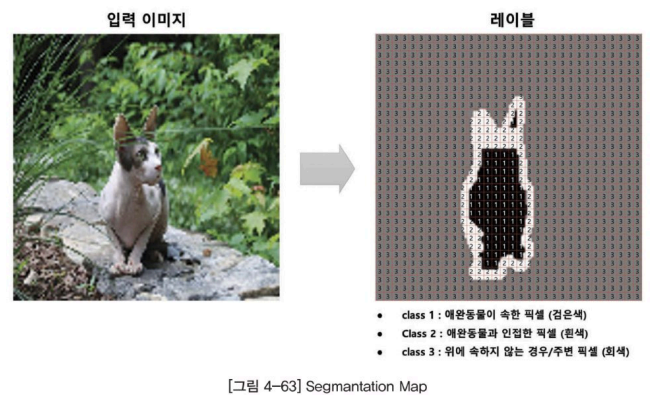


- 이미지 분할
 - 의미 분할 semantic segmentation: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분.
 - 인스턴스 분할 instance segmentation: 같은 범주에 속하더라도 서로 다른 객체를 구분.
 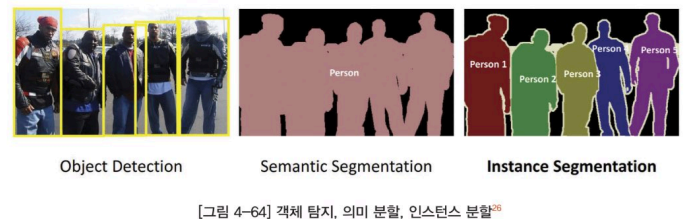

### 7-1 데이터셋 준비
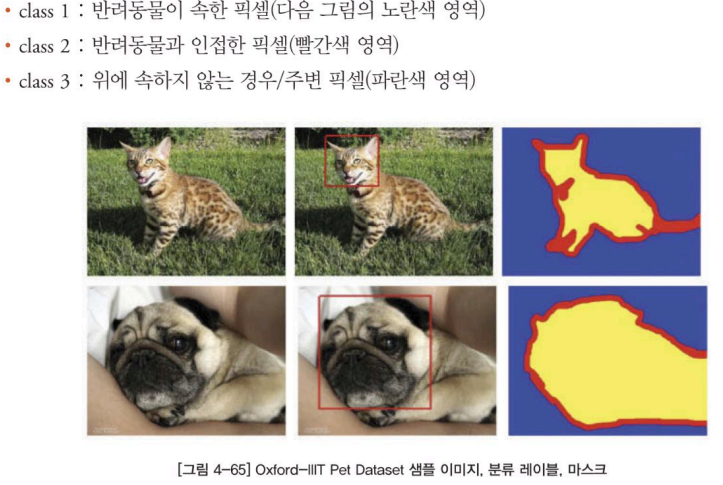

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
# 모델 학습에 필요한 입력 이미지의 크기와 학습 파라미터를 설정
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [3]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.LMRSUK_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.LMRSUK_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
''' 원본 이미지와 분할 마스크를 전처리하는 함수 정의:
이미지 크기를 사전 정의 크기로 변경, 자료형 변환,
원본 이미지의 픽셀 255로 나누어서 0~1 범위로 정규화, 마스크 0, 1, 2 정수형 값 갖도록 1 차감 '''
# 이미지 전처리 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'], (img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 1개 선택 - 배치에는 16개의 샘플 이미지와 마스크 이미지가 들어 있음.
img, mask = next(iter(train_ds))
len(img)

16

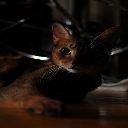

In [7]:
# 배치에서 첫 번째 이미지 출력 - 0~1 사이의 값이므로 255를 곱해서 정규화 이전의 원래 값 복원
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

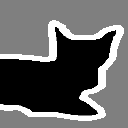

In [8]:
# 샘플 마스크 출력 - 마스크 값의 범위는 0~2이므로 2로 나눈 다음에 255 곱하면 RGB 표현 가능.
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

### 7-2 U-Net 모델 (인코더-디코더)
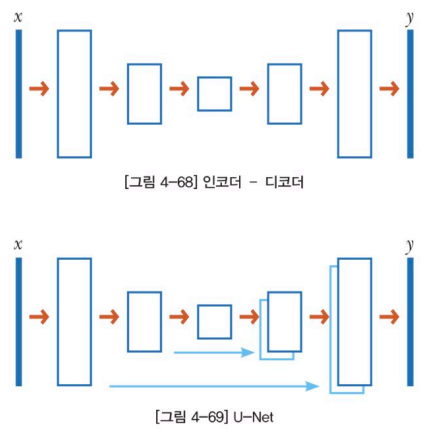

In [9]:
''' 사전 학습된 VGG16모델을 인코더로 활용하는 U-Net 모델을 만들어보자. '''
# 최종 레이어를 제외한 하고 VGG16 모델 불러오기
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top = False)

58889256/58889256 [==============================] - 1s 0us/step


- VGG16 모델: 합성곱 층과 풀링 층 직렬 연결 구조.
e.g. 모델 구조 (128, 128) 텐서 ~> 마지막 레이어에서 (4, 4) 크기로 축소.

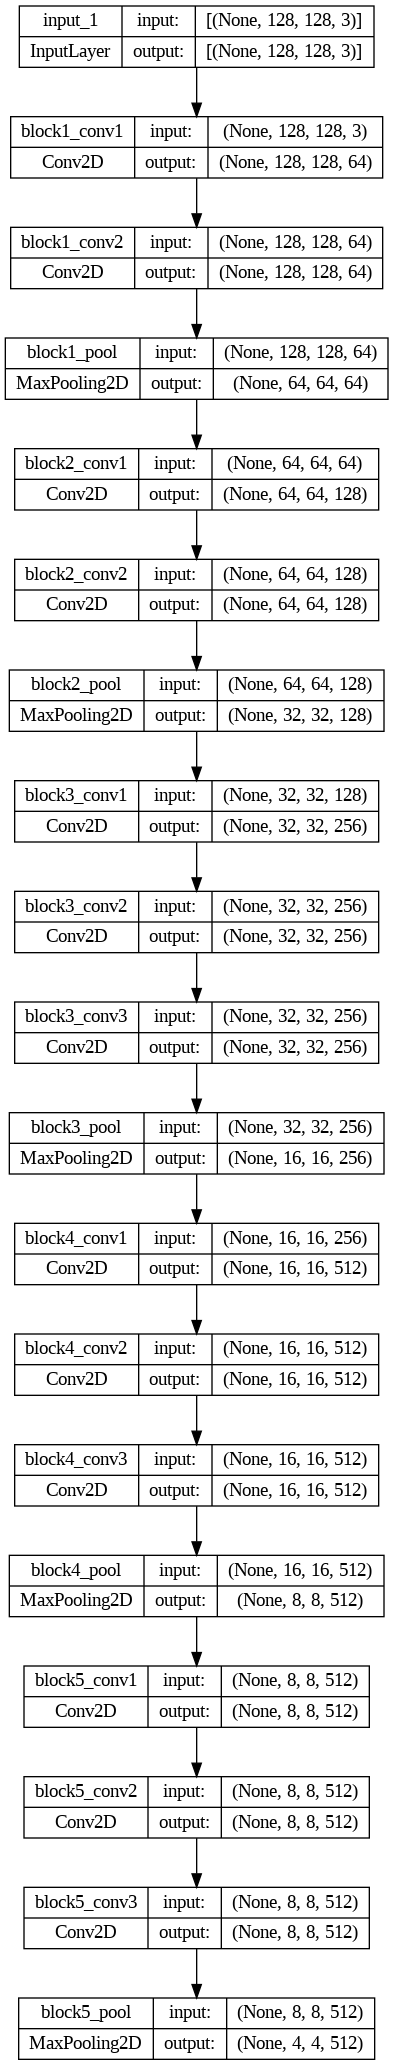

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [11]:
''' 만들고자 하는 U-net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 먼저 정함.
~> VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여, 다양한 피처를 추출하는 인코더 모델 정의 '''
''' 아래 코드는 VGG16 모델로부터 5개의 출력을 가져와서 사용 ~> Feature Extractor 모델 정의 ~> f_model 변수에 저장 '''
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                             base_model.get_layer(name='block5_conv3').output,
                             base_model.get_layer(name='block4_conv3').output,
                             base_model.get_layer(name='block3_conv3').output,
                             base_model.get_layer(name='block2_conv2').output,
                             base_model.get_layer(name='block1_conv2').output
                         ])

In [12]:
# 사전 학습된 파라미터를 인코더에 그대로 사용하기 위해서 업데이트되지 않도록 고정
f_model.trainable = False

In [13]:
''' 인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달 : 업샘플링(Up-Sampling)
; 축소된 이미지를 원래 이미지 크기로 복원하는 과정 '''
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3,3,activation='elu',padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

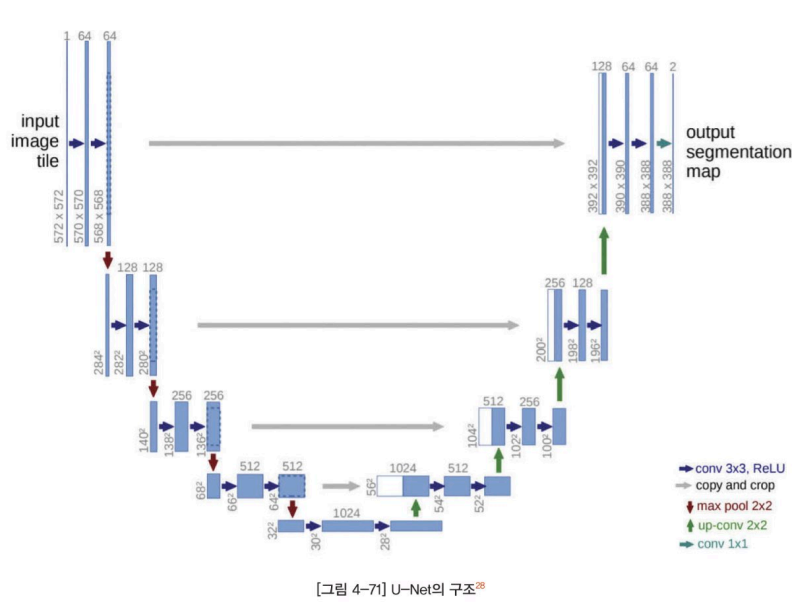

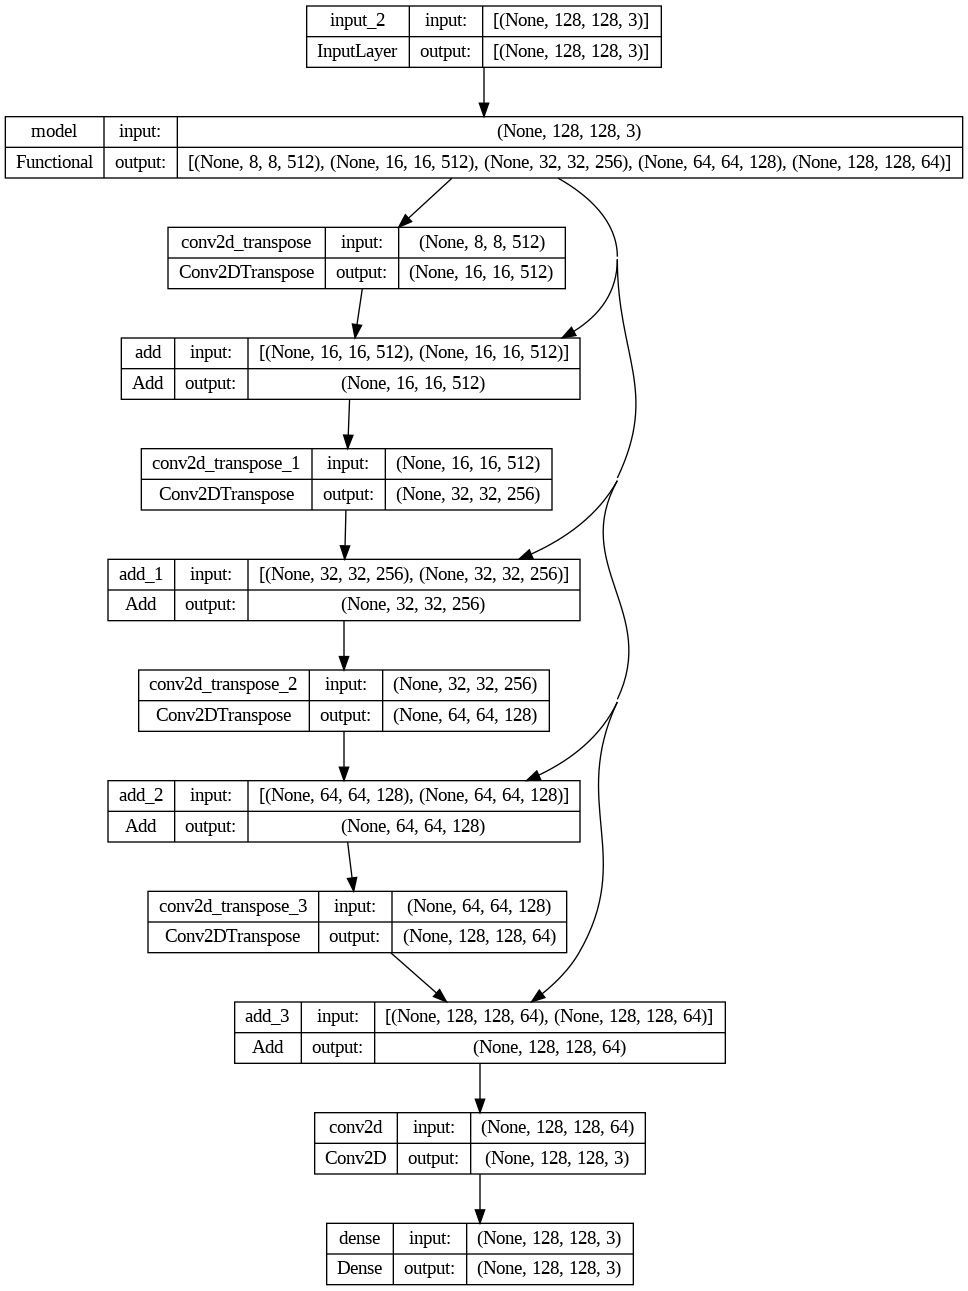

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

In [16]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1380s 6s/step - loss: 0.7276 - accuracy: 0.7311
Epoch 2/5
230/230 [==============================] - 1270s 6s/step - loss: 0.4678 - accuracy: 0.8171
Epoch 3/5
230/230 [==============================] - 1310s 6s/step - loss: 0.4180 - accuracy: 0.8355
Epoch 4/5
230/230 [==============================] - 1415s 6s/step - loss: 0.4012 - accuracy: 0.8423
Epoch 5/5
230/230 [==============================] - 1391s 6s/step - loss: 0.3843 - accuracy: 0.8489


1/1 [==============================] - 7s 7s/step


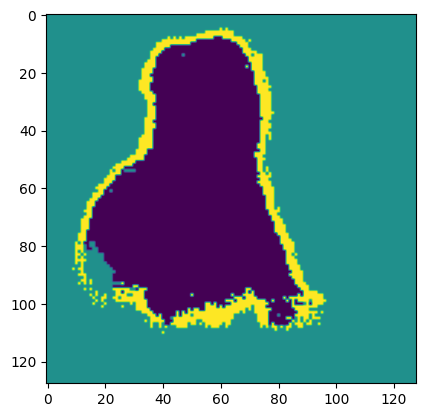

In [18]:
# 검증 셋의 배치를 하나 선택하고 predict() 메소드로 이미지 분할 클래스 예측
# 1개 배치(16개 이미지) 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번쨰 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

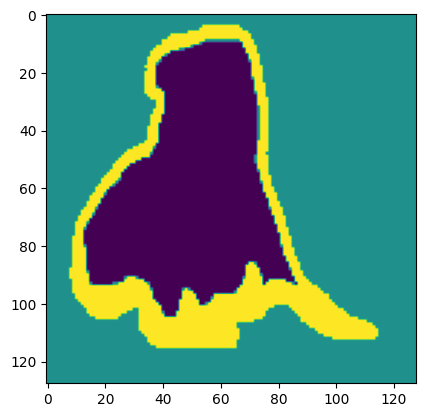

In [19]:
# 정답 마스크 이미지 출력 후 앞서 예측한 분할 이미지와 비교
# 첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))